### Nino資料實作
目標：利用FFT去除週期為一年以下的高頻波動

說明：在nindex.dat檔案中，有Nino1+2, Nino3, Nino34, Nino4四組資料，每組資料包含SST與SSTA (Anomaly)

---------------

Read the nino data

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

# Read the Nino data
fd = open('nindex.dat', 'r')
mydata = np.genfromtxt(fd,
                       dtype=('S10', 'float', 'float', 'float', 'float',
                              'float', 'float', 'float', 'float'),
                       delimiter=[10, 9, 4, 9, 4, 9, 4, 9, 4],
                       skip_header=3)
mydata = np.array(mydata,
         dtype=[('Week', '<S10'), ('Nino1+2_SST', '<f4'),
                ('Nino1+2_SSTA', '<f4'), ('Nino3_SST', '<f4'),
                ('Nino3_SSTA', '<f4'), ('Nino34_SST', '<f4'),
                ('Nino34_SSTA', '<f4'), ('Nino4_SST', '<f4'),
                ('Nino4_SSTA', '<f4')])
fd.close()

ex: Fourier Transform with General Formulas (Sine/Cosine Function)

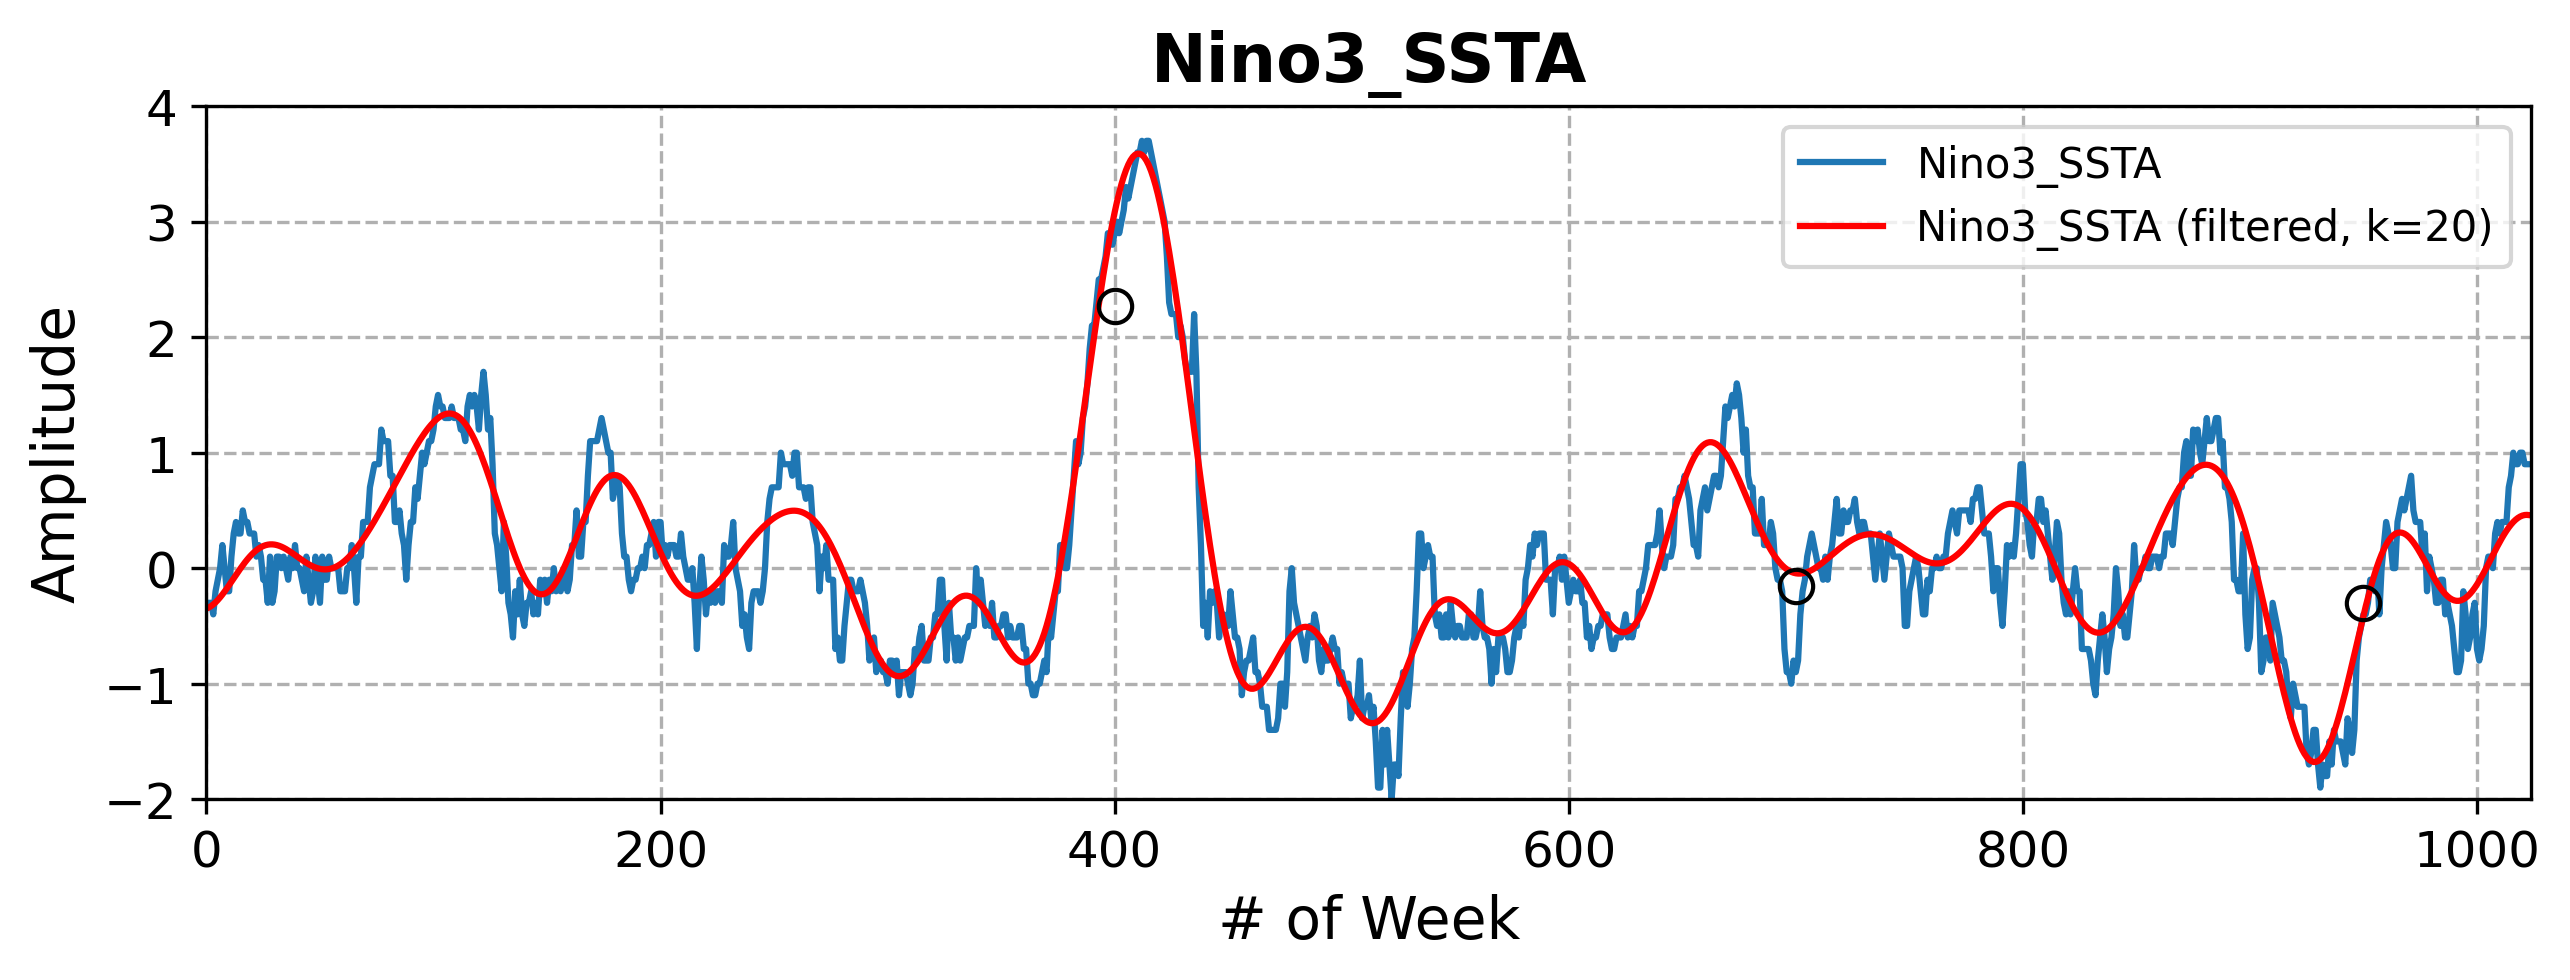

In [8]:
n1 = 'Nino3_SSTA'
ns = 1024  # 20年資料
# ns = 1081  # 20年資料
x = mydata[n1][0:ns]
m = x.size  # Window length
pt = np.arange(m)

no = 101  # 取到第101項
D = np.zeros((m, no))
D3 = np.zeros((3, no))
in3 = np.array([400.0, 700.0, 950.0])
D[:, 0] = 1
a = np.zeros((no))

for i in range(1, no, 2):
    D[:, i] = np.cos(i * np.pi * pt / m)
    D3[:, i] = np.cos(i * np.pi * in3 / m)
    a[i] = (2 / m) * np.inner(x, np.cos(i * np.pi * pt / ns))

for i in range(2, no, 2):
    D[:, i] = np.sin((i - 1) * np.pi * pt / m)
    D3[:, i] = np.cos((i - 1) * np.pi * in3 / m)
    a[i] = (2 / m) * np.inner(x, np.sin((i - 1) * np.pi * pt / ns))

a[0] = np.sum(x) / m
# a[1:41] = 0.0       # 濾除波數為20以下的波 (濾除週期大約為一年以上的波振幅設為0)
a[41::] = 0.0       # 濾除波數為20以上的波 (週期大約為一年以下的波的振幅設為0)
yr = np.inner(D, a)
yy = np.inner(D3, a)

# Plot time series
plt.figure(figsize=(10, 3), dpi=300)
ax = plt.gca()
plt.plot(pt, x)
plt.plot(pt, yr, color='red')
plt.plot(in3,
         yy,
         marker='o',
         markersize=8,
         linestyle='None',
         markerfacecolor='None',
         markeredgecolor='black')
ax.set_xlim([0, ns])
ax.set_ylim([-2, 4])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(n1, fontsize=16, fontweight="bold")
plt.xlabel('# of Week', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.grid(linestyle='--')
plt.legend([f'{n1}', f'{n1} (filtered, k=20)'])
plt.savefig('Nino3_SSTA_formula.jpg',
            bbox_inches='tight')

ex: Fourier/Inversed Fourier Transform with FFT function from Scipy

/Users/robinhsieh/Programming/Python/NumericalAnalysis/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


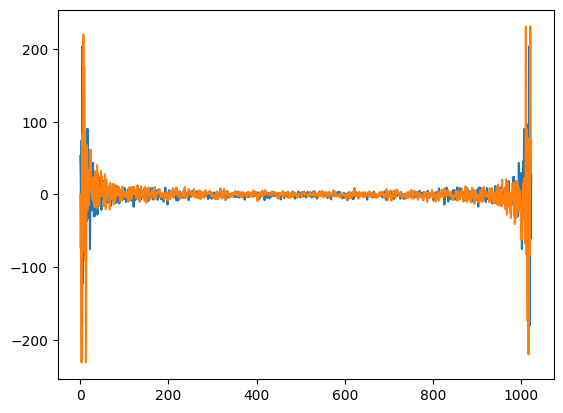

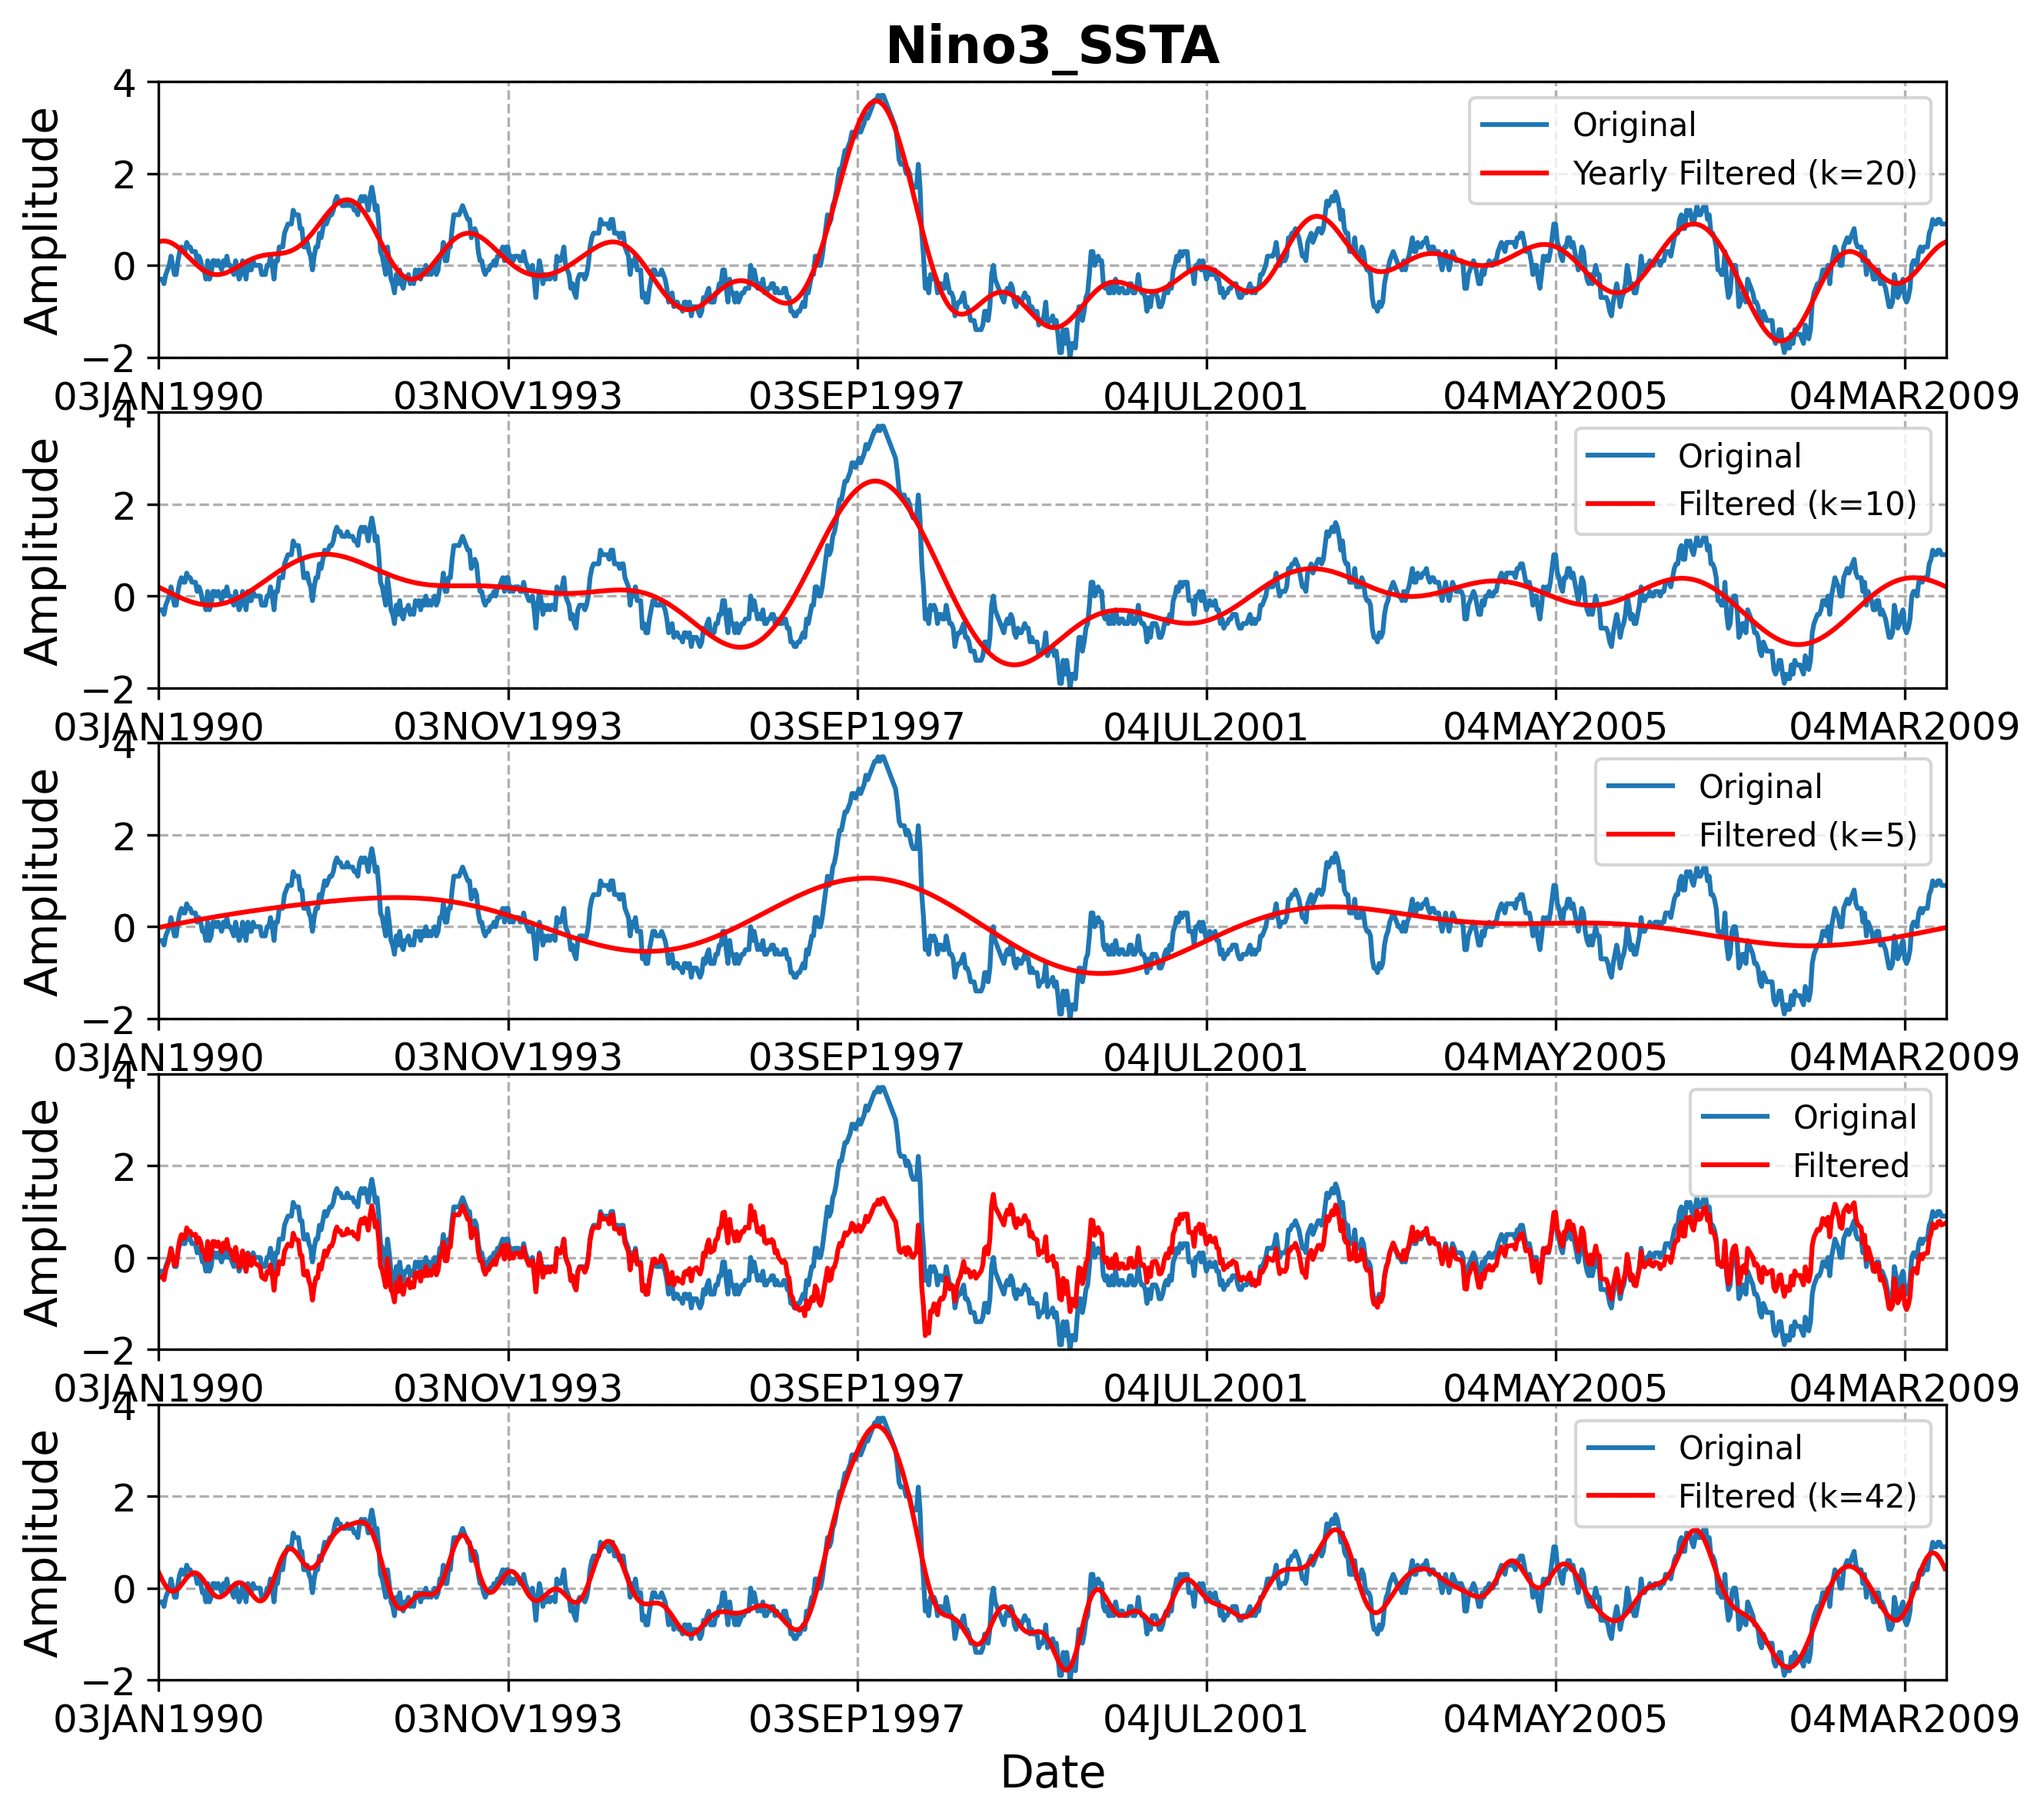

In [9]:
yf = fft(x)

# ------------------------------self code
plt.plot(yf.real)
plt.plot(yf.imag)

y0 = yf.copy()

k = 10
y0[1:1 + k - 1] = 0
y0[ns - k:ns] = 0
yt_self = ifft(y0, ns)
# ------------------------------self code
k = round(m / 24)
y01 = np.zeros(ns, dtype=complex)

y01[0] = yf[0]
y01[1:1 + k - 1] = yf[1:1 + k - 1]
y01[ns - k:ns] = yf[ns - k:ns]  #conjugate
yt_42 = ifft(y01, ns)  #把濾過的波轉回原本的t space
# ------------------------------self code
y1 = np.zeros(ns, dtype=complex)  #轉完的資料為complex形式
# print('yf=', yf)

k = 20  #總共20年的資料，濾除一年以下，波數取20
y1[0] = yf[0]
y1[1:1 + k - 1] = yf[1:1 + k - 1]
y1[ns - k:ns] = yf[ns - k:ns]  #conjugate
yt_20 = ifft(y1, ns)  #把濾過的波轉回原本的t space

y2 = np.zeros(ns, dtype=complex)
k = 10  #總共20年的資料，波數取10
y2[0] = yf[0]
y2[1:1 + k - 1] = yf[1:1 + k - 1]
y2[ns - k:ns] = yf[ns - k:ns]  #conjugate
yt_10 = ifft(y2, ns)  #把濾過的波轉回原本的t space

y3 = np.zeros(ns, dtype=complex)
k = 5  #總共20年的資料，波數取5
y3[0] = yf[0]
y3[1:1 + k - 1] = yf[1:1 + k - 1]
y3[ns - k:ns] = yf[ns - k:ns]  #conjugate
yt_5 = ifft(y3, ns)  #把濾過的波轉回原本的t space

#畫圖
date = []
for i in range(len(mydata['Week'])):
    date.append(mydata['Week'][i].decode('UTF-8')[1::])

plt.figure(figsize=(10, 9), dpi=300)

axs = plt.subplot(5, 1, 1)
axs.plot(pt, x)  #原本資料
axs.plot(pt, yt_20, color='red')  #濾波後的資料
axs.set_xlim([0, ns])
axs.set_ylim([-2, 4])
plt.xticks([0, 200, 400, 600, 800, 1000],
           date[0:1200:200])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(n1, fontsize=16, fontweight="bold")
plt.ylabel('Amplitude', fontsize=14)
axs.grid(linestyle='--')
plt.legend(['Original', 'Yearly Filtered (k=20)'])

axs = plt.subplot(5, 1, 2)
axs.plot(pt, x)  #原本資料
axs.plot(pt, yt_10, color='red')  #濾波後的資料
axs.set_xlim([0, ns])
axs.set_ylim([-2, 4])
plt.xticks([0, 200, 400, 600, 800, 1000],
           date[0:1200:200])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Amplitude', fontsize=14)
axs.grid(linestyle='--')
plt.legend(['Original', 'Filtered (k=10)'])

axs = plt.subplot(5, 1, 3)
axs.plot(pt, x)  #原本資料
axs.plot(pt, yt_5, color='red')  #濾波後的資料
axs.set_xlim([0, ns])
axs.set_ylim([-2, 4])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks([0, 200, 400, 600, 800, 1000],
           date[0:1200:200])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
axs.grid(linestyle='--')
plt.legend(['Original', 'Filtered (k=5)'])

# ------------------------------self code
axs = plt.subplot(5, 1, 4)
axs.plot(pt, x)  #原本資料
axs.plot(pt, yt_self, color='red')  #濾波後的資料
axs.set_xlim([0, ns])
axs.set_ylim([-2, 4])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks([0, 200, 400, 600, 800, 1000],
           date[0:1200:200])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
axs.grid(linestyle='--')
plt.legend(['Original', 'Filtered'])
# ------------------------------self code
axs = plt.subplot(5, 1, 5)
axs.plot(pt, x)  #原本資料
axs.plot(pt, yt_42, color='red')  #濾波後的資料
axs.set_xlim([0, ns])
axs.set_ylim([-2, 4])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks([0, 200, 400, 600, 800, 1000],
           date[0:1200:200])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
axs.grid(linestyle='--')
plt.legend(['Original', 'Filtered (k=42)'])
# ------------------------------self code

plt.savefig('Nino3_SSTA_Scipy.jpg', bbox_inches='tight')
plt.show()

頻譜分析

Text(0, 0.5, 'Intensity')

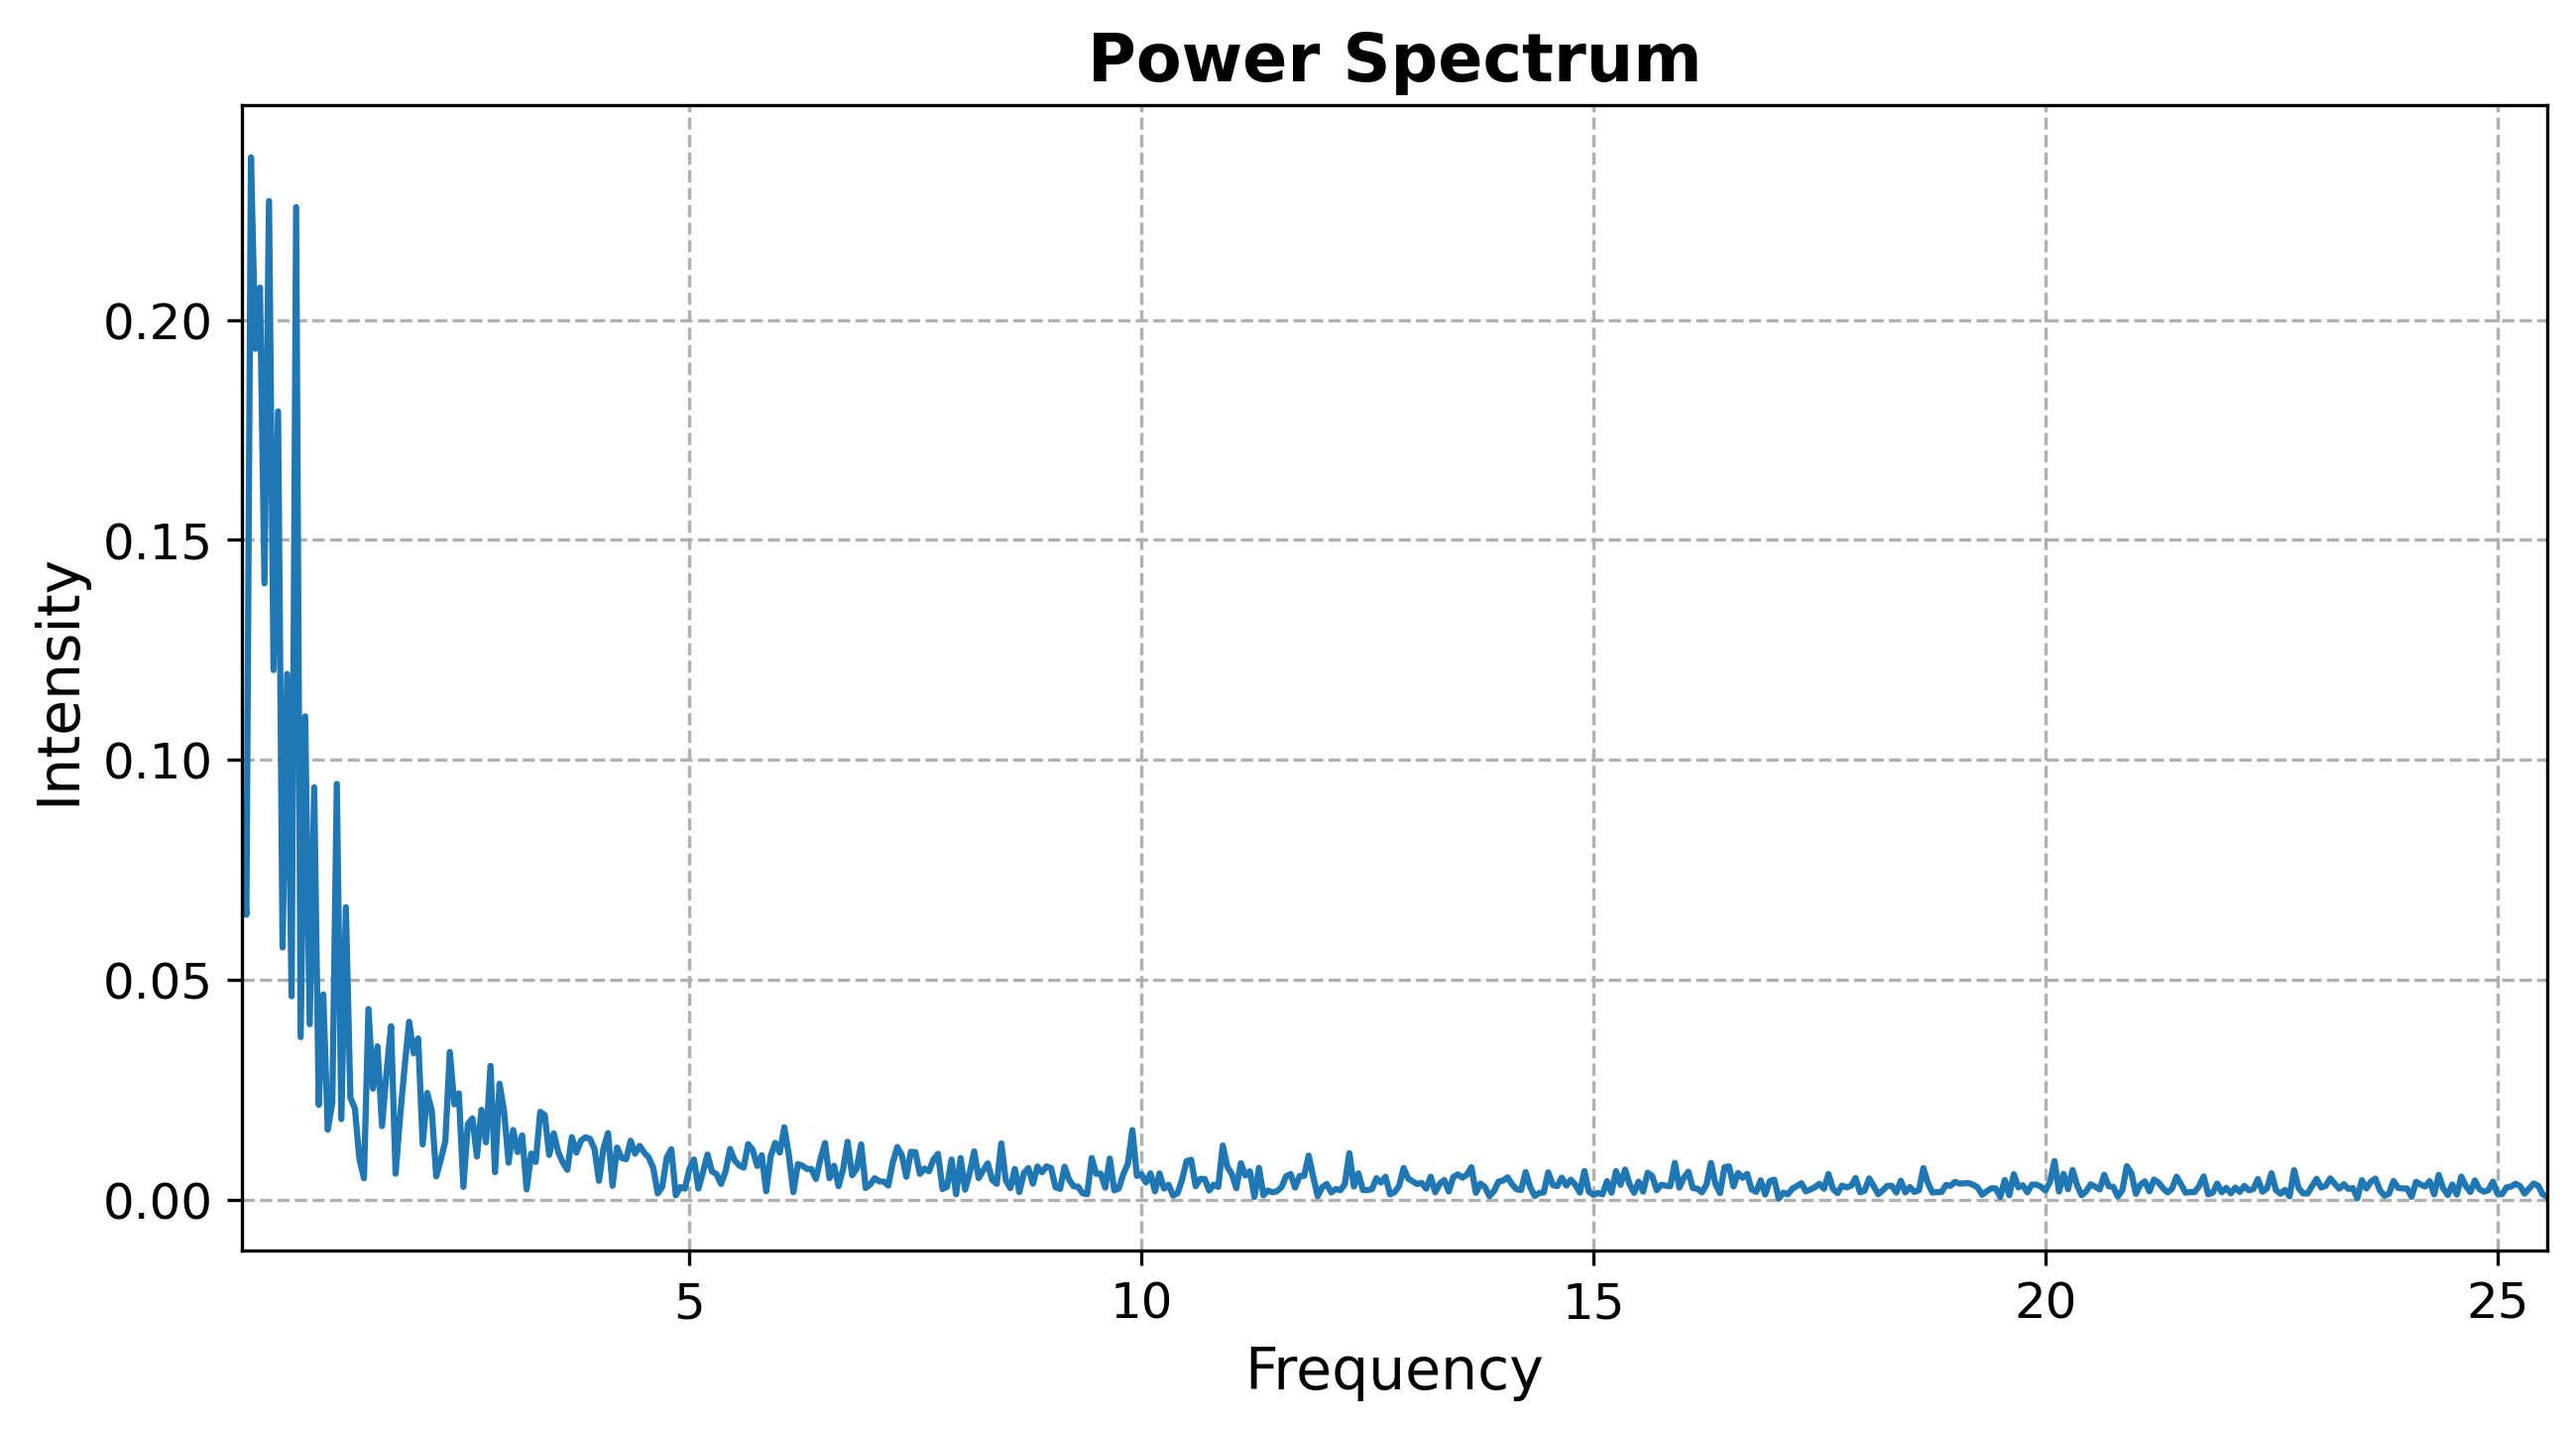

In [14]:
#FFT Power spectrum
# dt = 1/m
dt = 20/m  # m=1024

yf = fft(x)
xf = fftfreq(m, dt)[:m//2]

plt.figure(figsize=(10, 5), dpi=300)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.plot(xf[1:], 1.0/m * np.abs(yf[1:m//2]))

plt.title("Power Spectrum", fontsize=16, fontweight="bold")

plt.grid(linestyle='--')
plt.xlim(xf[1], xf[-1])

plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Intensity', fontsize=14)